# Using Transformations

This notebook focuses on the general usage of transformations rather than specific details of each transformation, which can be found in the [documentation](https://sigment.readthedocs.io/en/latest/sections/transformations.html).

---

**Contents**:

- [I/O](#I/O)
  - [Manually importing a signal with LibROSA](#Manually-importing-a-signal-with-LibROSA)
    - [Importing and plotting the raw signal](#Importing-and-plotting-the-raw-signal)
    - [Applying a time stretch and plotting the transformed signal](#Applying-a-time-stretch-and-plotting-the-transformed-signal)
  - [Automatically importing a signal](#Automatically-importing-a-signal)
    - [Importing the signal, applying normalization and plotting the transformed signal](#Importing-the-signal,-applying-normalization-and-plotting-the-transformed-signal)
    - [Generating multiple augmented signals](#Generating-multiple-augmented-signals)
    - [Re-writing the transformed signal to a WAV file](#Re-writing-the-transformed-signal-to-a-WAV-file)
- [Value ranges](#Value-ranges)
  - [Reproducible randomness](#Reproducible-randomness)
- [Probabilistic transformations](#Probabilistic-transformations)

In [1]:
import matplotlib.pyplot as plt
from librosa import load
from sigment.transforms import *
from utils import plot
plt.style.use('ggplot')

## I/O

### Manually importing a signal with LibROSA

Sigment only supports 32-bit floating point WAV audio with samples in range $[-1,1]$.

The [`librosa.core.load`](https://librosa.github.io/librosa/generated/librosa.core.load.html) function provided by LibROSA automatically converts WAV files with various representations into appropriate 32-bit floating point signals  by default. Therefore, we suggest using this function if you choose to manually import audio. 

Another reason for this is that signals imported with LibROSA are of shape $n_\text{channels} \times n_\text{samples}$, which is the same as the convention used in Sigment, unlike [``soundfile.read``](https://pysoundfile.readthedocs.io/en/latest/#soundfile.read) which uses the transposed representation. 

As LibROSA is the most commonly used library for audio processing and visualization, we chose to follow their conventions.

#### Importing and plotting the raw signal

Setting `mono=False` allows for the support of both mono and stereo signals, by always ensuring that stereo signals are **not** converted to mono.

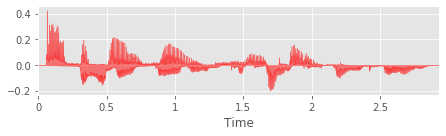

In [2]:
X, sr = load('assets/audio.wav', mono=False)
plot(X, sr=sr)

#### Applying a time stretch and plotting the transformed signal

The `TimeStretch` transformation can be used to stretch the duration or speed of the signal, without affecting its pitch.

Here we slow down the audio by 10% of the original speed.

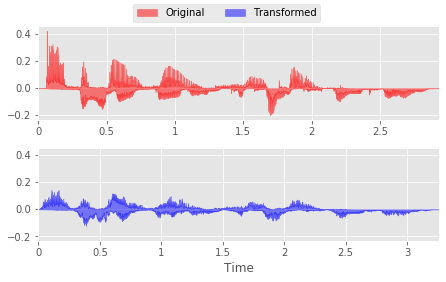

In [3]:
X_stretch = TimeStretch(rate=0.9)(X)
plot(X, X_stretch, sr=sr)

### Automatically importing a signal

To avoid having to manually load audio, Sigment provides two functions to assist with I/O:

- `generate_from_wav`: Loads a WAV audio signal, applies a transformation and returns a NumPy array.
- `apply_to_wav`: Loads a WAV audio signal, apples a transformation and writes it to either a new WAV file or the original one.

Both functions will convert and treat the audio as a 32-bit floating point signal.

#### Importing the signal, applying normalization and plotting the transformed signal

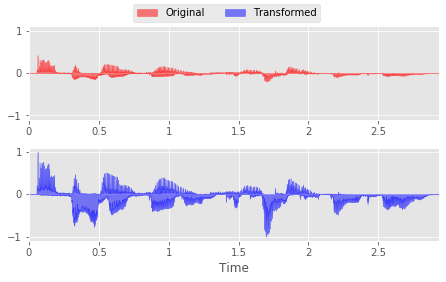

In [4]:
X_norm = Normalize(independent=True).generate_from_wav('assets/audio.wav')
plot(X, X_norm, sr=sr)

#### Generating multiple augmented signals

The `generate_from_wav` function accepts a parameter `n`, which species how many augmentations to generate (defaults to 1). 

For deterministic transformations such as normalization, this is quite pointless as each augmentation will be the same.<br/> However, when using [value ranges](#Value-ranges), [probabilistic transformations](#Probabilistic-transformations) or generating augmented signals using a `Quantifier`, this feature can be useful.

```python
Normalize(independent=True).generate_from_wav('assets/audio.wav', n=5)
```

#### Re-writing the transformed signal to a WAV file

The `apply_to_wav` function accepts an optional second argument that specifies where to store the transformed signal. If no argument is given, then this **will overwrite** the original WAV file.

```python
Normalize(independent=True).apply_to_wav('assets/audio.wav', 'assets/normalized.wav')
```

**Note**: When saving the transformed audio signal, it is always normalized to fit in the necessary $[-1,1]$ range for 64-bit WAV files.

## Value ranges

Most transformations offered by Sigment accept one or more numerical parameters.

For example, the `RandomCrop` transformation randomly removes `n_crops` sections of duration `crop_size` from a signal, where `crop_size` is a fraction of the original signal duration.

```python
# Crop 5 sections, each 5% of the original signal length
RandomCrop(n_crops=5, crop_size=0.05)(X)
```

![Randomly crop 5 sections - each 5% of the original signal length](assets/audio-crop1.svg)

For data augmentation, it is often desirable to introduce randomness to our transformations. In the case of `RandomCrop`, we might want to: 

- randomly pick the number of cropped sections from a range of values (e.g. 3 to 5),
- randomly pick the size of each cropped section from a range of values (e.g. 1% to 10%).

Instead of specifying a single value for each of these parameters, it is possible to specify a tuple $(a, b)$ which:

- for a discrete parameter (e.g. `n_crops`), selects an integer $x\in\{a,\ldots, b\}$,
- for a continuous parameter (e.g. `crop_size`), selects a value $x\sim\text{Uniform}(a, b)$.

```python
# Crop 3 to 5 sections, each between 1% and 10% of the original signal length
RandomCrop(n_crops=(3, 5), crop_size=(0.01, 0.1))(X)
```

![Randomly crop 3-5 sections - each 1-10% of the original signal length](assets/audio-crop2.svg)

### Reproducible randomness

For reproducible randomness, all transformations accept a `random_state` parameter which can be set to an `int`, `numpy.random.RandomState` object, or `None` (the default value, in which case the transformation is completely random each time):

```python
# Create a numpy.random.RandomState seed
seed = np.random.RandomState(0)
# Crop 3 to 5 sections, each between 1% and 10% of the original signal length
RandomCrop(n_crops=(3, 5), crop_size=(0.01, 0.1), random_state=seed)(X)
```

## Probabilistic transformations

While value ranges introduce some randomness to transformations, sometimes it might be desirable to have some probability of **not** applying a particular transformation — especially when using `Quantifier` objects to create large and complex data augmentation pipelines.

Each transformation accepts a `p` parameter (defaults to 1) which specifies the probability that the transformation is applied to the signal.

As with value ranges, the `random_state` parameter can also be used to control and reproduce the randomness of the `p` parameter.

```python
# Create a numpy.random.RandomState seed
seed = np.random.RandomState(0)
# Crop 3 to 5 sections, each between 1% and 10% of the original signal length, but only with probability 0.7
RandomCrop(n_crops=(3, 5), crop_size=(0.01, 0.1), random_state=seed, p=0.7)(X)
```